In [15]:
import json
from collections import Counter
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import ssl
import numpy as np 
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/volthai7us/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
def clean_and_split(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

In [36]:
def most_common_words_of_speaker(speaker): 
    file_path = f'./data/transcripts/friends-1-227-{speaker}-pair.json'

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
    all_answers = ' '.join(item['answer'] for item in data)

    words = clean_and_split(all_answers)

    stop_words = set(stopwords.words('english'))

    filtered_words = [word for word in words if word not in [*stop_words, 'joey', 'chandler', 'monica', 'phoebe', 'rachel', 'ross']]

    word_counts = Counter(filtered_words)
    
    total_words = sum(word_counts.values())

    most_common_words = [(word, count / total_words * 100) for word, count in word_counts.most_common(20)]
    
    return most_common_words

In [37]:
speakers = ("Rachel", "Chandler", "Phoebe", "Monica", "Ross", "Joey")

all_commons = {}
for speaker in speakers:
    all_commons[speaker] = most_common_words_of_speaker(speaker=speaker)

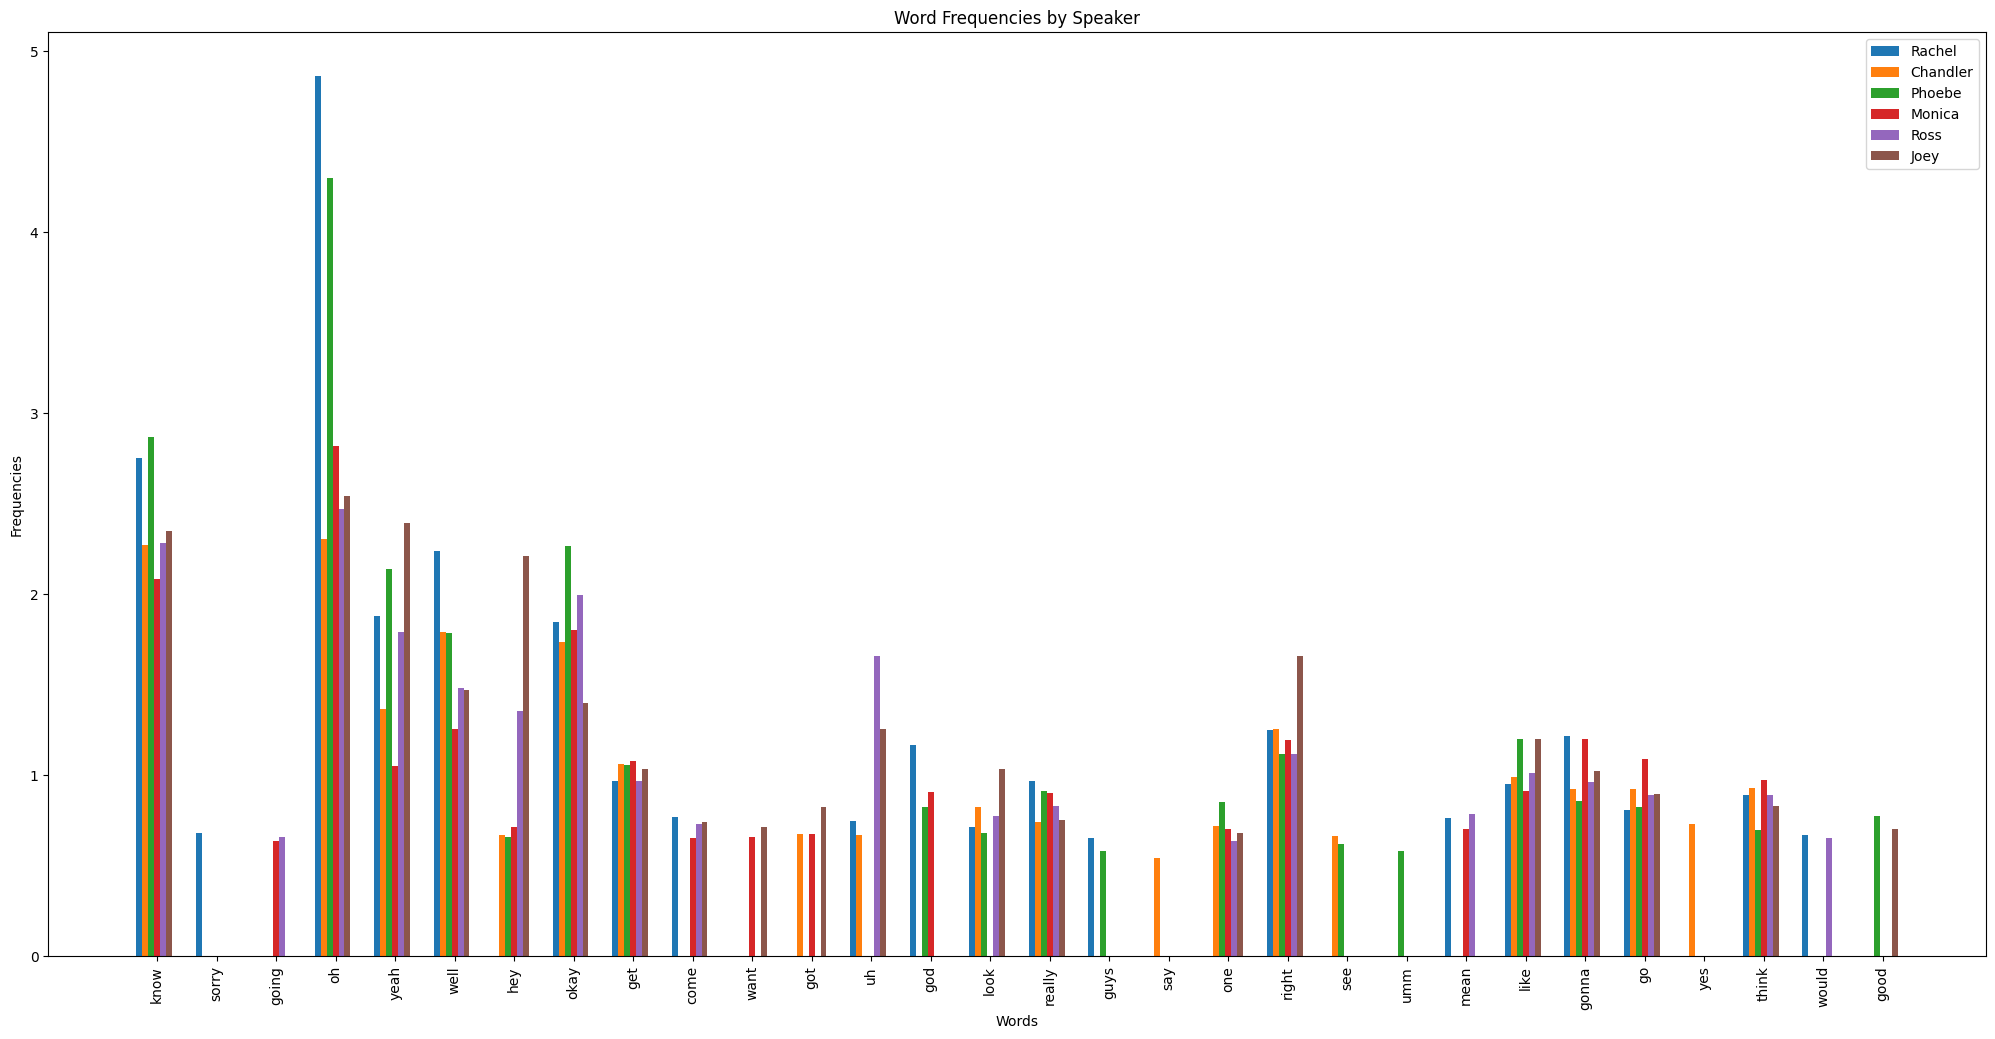

In [38]:
unique_words = set(word for speaker in all_commons.values() for word, _ in speaker)

# Her konuşmacı için frekansları hesaplama
frequencies = {speaker: {word: freq for word, freq in all_commons[speaker]} for speaker in all_commons}

# Grafik için x eksenindeki pozisyonları ayarlama
n_words = len(unique_words)
ind = np.arange(n_words)
width = 0.1  # bar genişliği

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(25, 12))

for i, speaker in enumerate(all_commons):
    speaker_freqs = [frequencies[speaker].get(word, 0) for word in unique_words]
    ax.bar(ind + i*width, speaker_freqs, width, label=speaker)

# Eksenleri ve başlığı ayarlama
ax.set_xlabel('Words')
ax.set_ylabel('Frequencies')
ax.set_title('Word Frequencies by Speaker')
ax.set_xticks(ind + width * len(all_commons) / 2)
ax.set_xticklabels(unique_words, rotation='vertical')
ax.legend()

plt.show()

In [20]:
f = open("./data/other/word-to-emotion.txt", "r")

data = f.read()

In [21]:
lines = data.strip().split("\n")
rows = [line.split("\t") for line in lines]
df_emotion = pd.DataFrame(rows, columns=["word", "emotion", "score"])

# 'score' sütununu sayısal tipe dönüştürün
df_emotion["score"] = pd.to_numeric(df_emotion["score"])

# Veri çerçevesini yeniden şekillendirin
df_emotion = df_emotion.pivot(index='word', columns='emotion', values='score')

# Sonucu gösterin
df_emotion.head()

emotion,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
word,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [22]:
def emotions_of_speaker(df, speaker):
    file_path = f'./data/transcripts/friends-1-227-{speaker}-pair.json'

    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
    all_answers = ' '.join(item['answer'] for item in data)

    words = clean_and_split(all_answers)

    stop_words = set(stopwords.words('english'))

    filtered_words = [word for word in words if word not in [*stop_words, 'joey', 'chandler', 'monica', 'phoebe', 'rachel', 'ross']]

    word_counts = Counter(filtered_words)

    total_words = sum(word_counts.values())

    most_common_words = [(word, count / total_words * 100) for word, count in word_counts.most_common(1000)]
    
    emotion_scores = {emotion: 0 for emotion in df_emotion.columns.unique()}

    # Her kelime için duygu skorlarını hesaplayın ve frekanslarını kullanarak ağırlıklandırın
    for word, frequency in most_common_words:
        if word in df_emotion.index:
            word_scores = df_emotion.loc[word]
            for emotion in df_emotion.columns:
                emotion_scores[emotion] += word_scores[emotion] * frequency


    return emotion_scores

In [23]:
all_emotions = {}

for speaker in speakers:
    emotions = emotions_of_speaker(df_emotion, speaker=speaker)
    all_emotions[speaker] = emotions

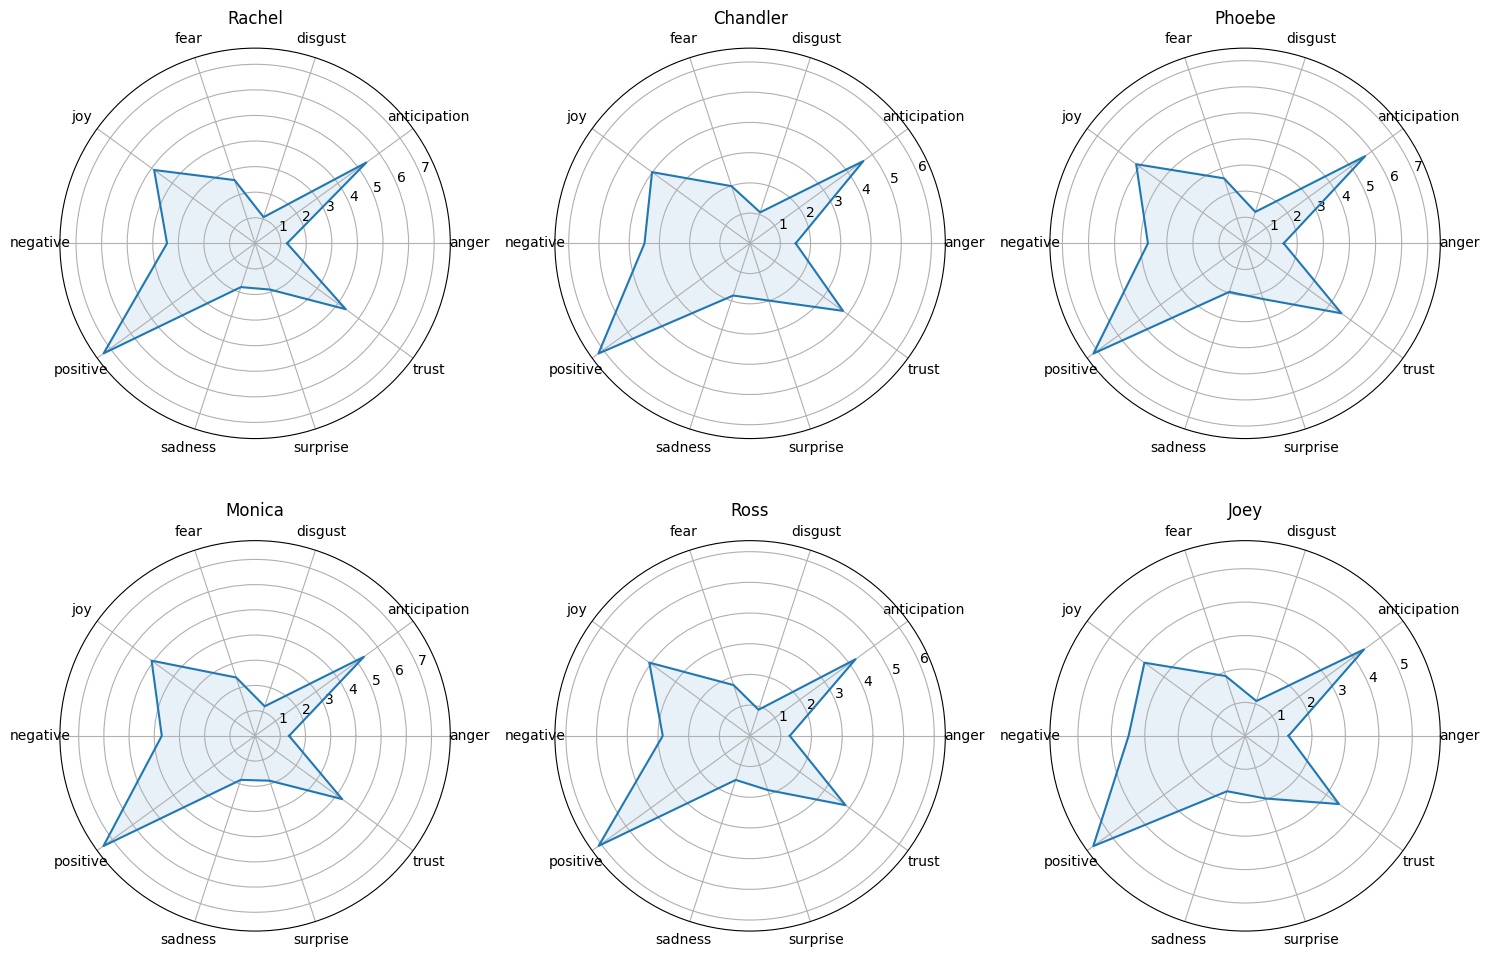

In [24]:
# 2 satır ve 3 sütunlu bir ızgara oluştur
fig, axs = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(polar=True))
axs = axs.flatten() # 2D ızgara düzenini 1D listeye dönüştür

# Her konuşmacı için bir radar grafiği çiz
for ax, (speaker, scores) in zip(axs, all_emotions.items()):
    values = list(scores.values())
    categories = list(scores.keys())
    N = len(categories)
    values += values[:1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax.set_xticks(angles[:-1], categories)
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.1)
    ax.set_title(speaker)

# Grafikleri göster
plt.tight_layout()
plt.show()

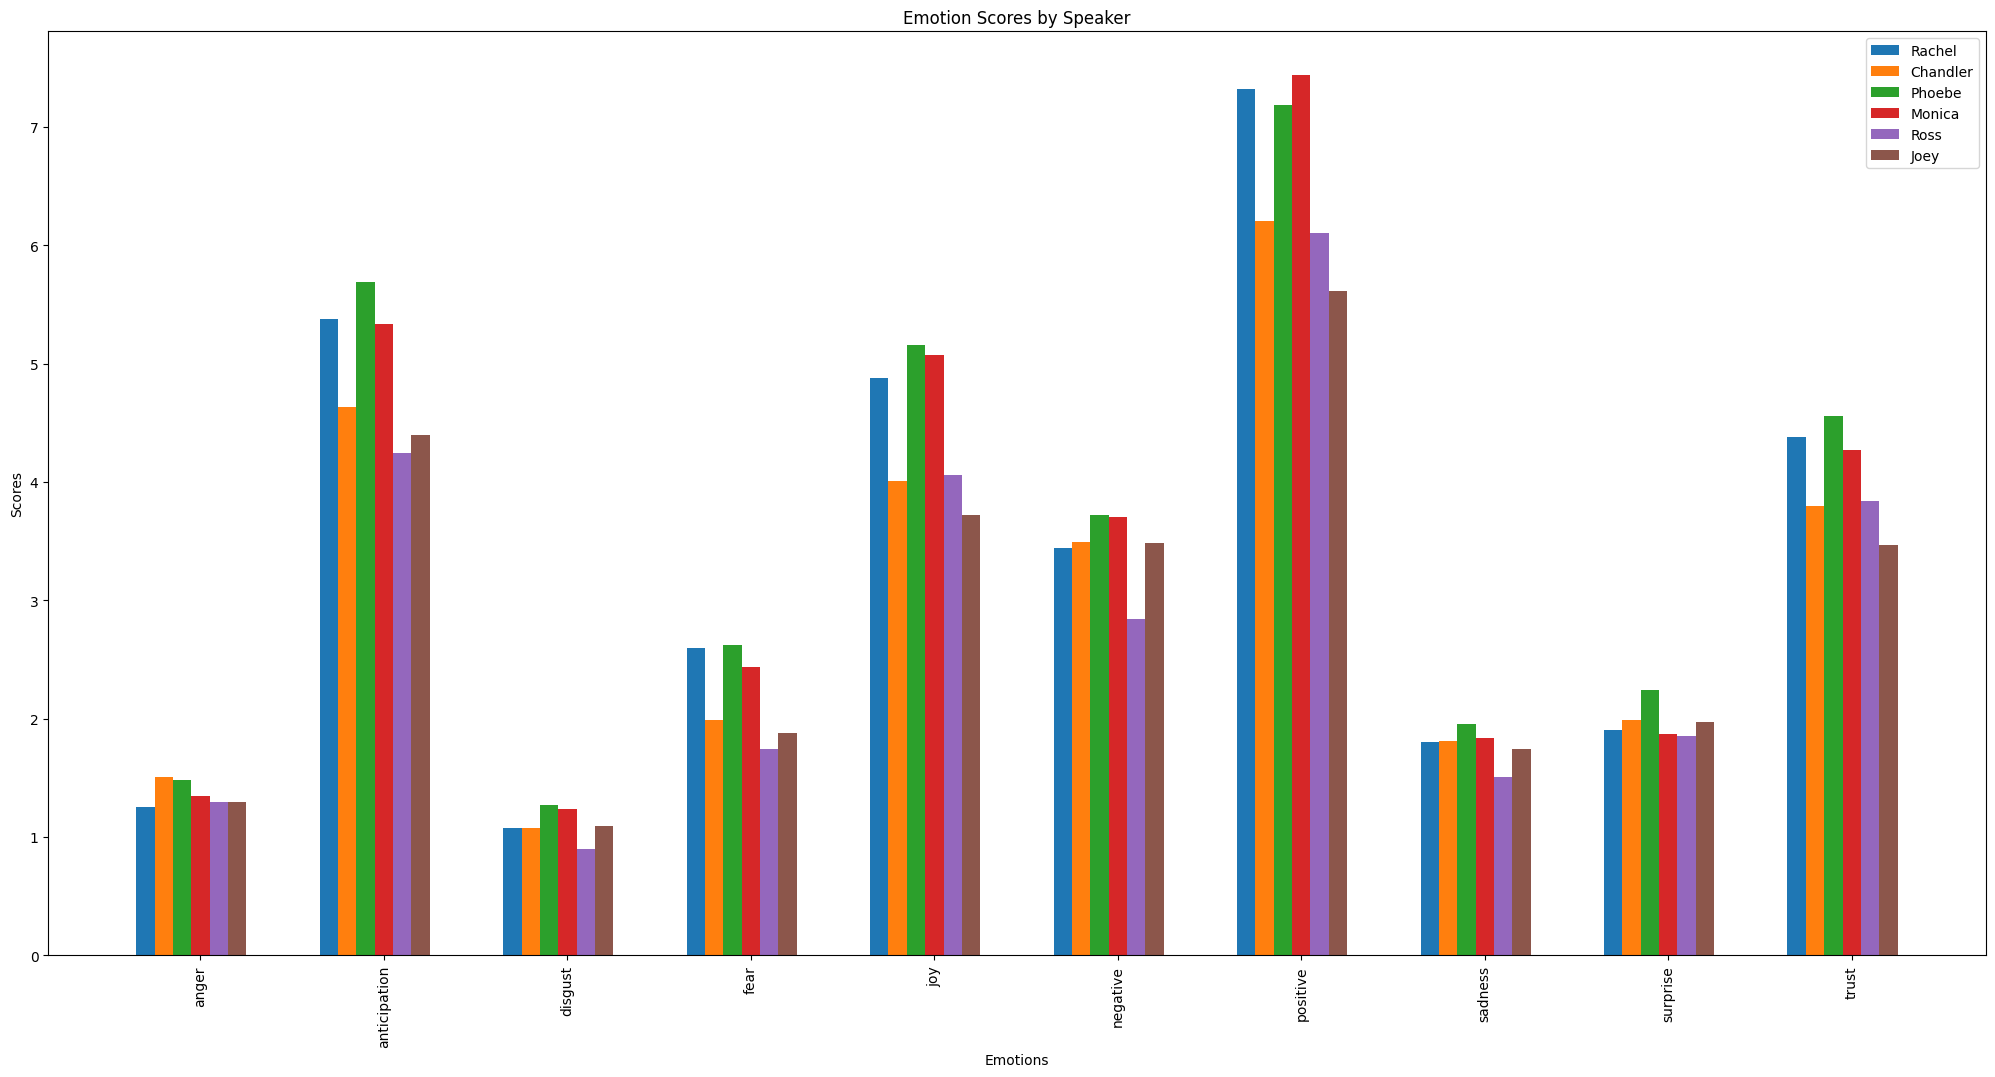

In [25]:
# Duygu kategorileri ve konuşmacılar
emotions = list(all_emotions["Chandler"].keys())
speakers = list(all_emotions.keys())

# Grafik ayarları
num_emotions = len(emotions)
num_speakers = len(speakers)
bar_width = 0.1  # Bar genişliği
ind = np.arange(num_emotions)  # Duygu kategorileri için x eksenindeki konumlar

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(25, 12))

for i, speaker in enumerate(speakers):
    # Her konuşmacının skorlarını al
    speaker_scores = [all_emotions[speaker][emotion] for emotion in emotions]

    # Barları çiz
    ax.bar(ind + i * bar_width, speaker_scores, bar_width, label=speaker)

# Eksenleri ve başlığı ayarlama
ax.set_xlabel('Emotions')
ax.set_ylabel('Scores')
ax.set_title('Emotion Scores by Speaker')
ax.set_xticks(ind + bar_width * num_speakers / 2)
ax.set_xticklabels(emotions, rotation='vertical')
ax.legend()

# Grafik gösterimi
plt.show()

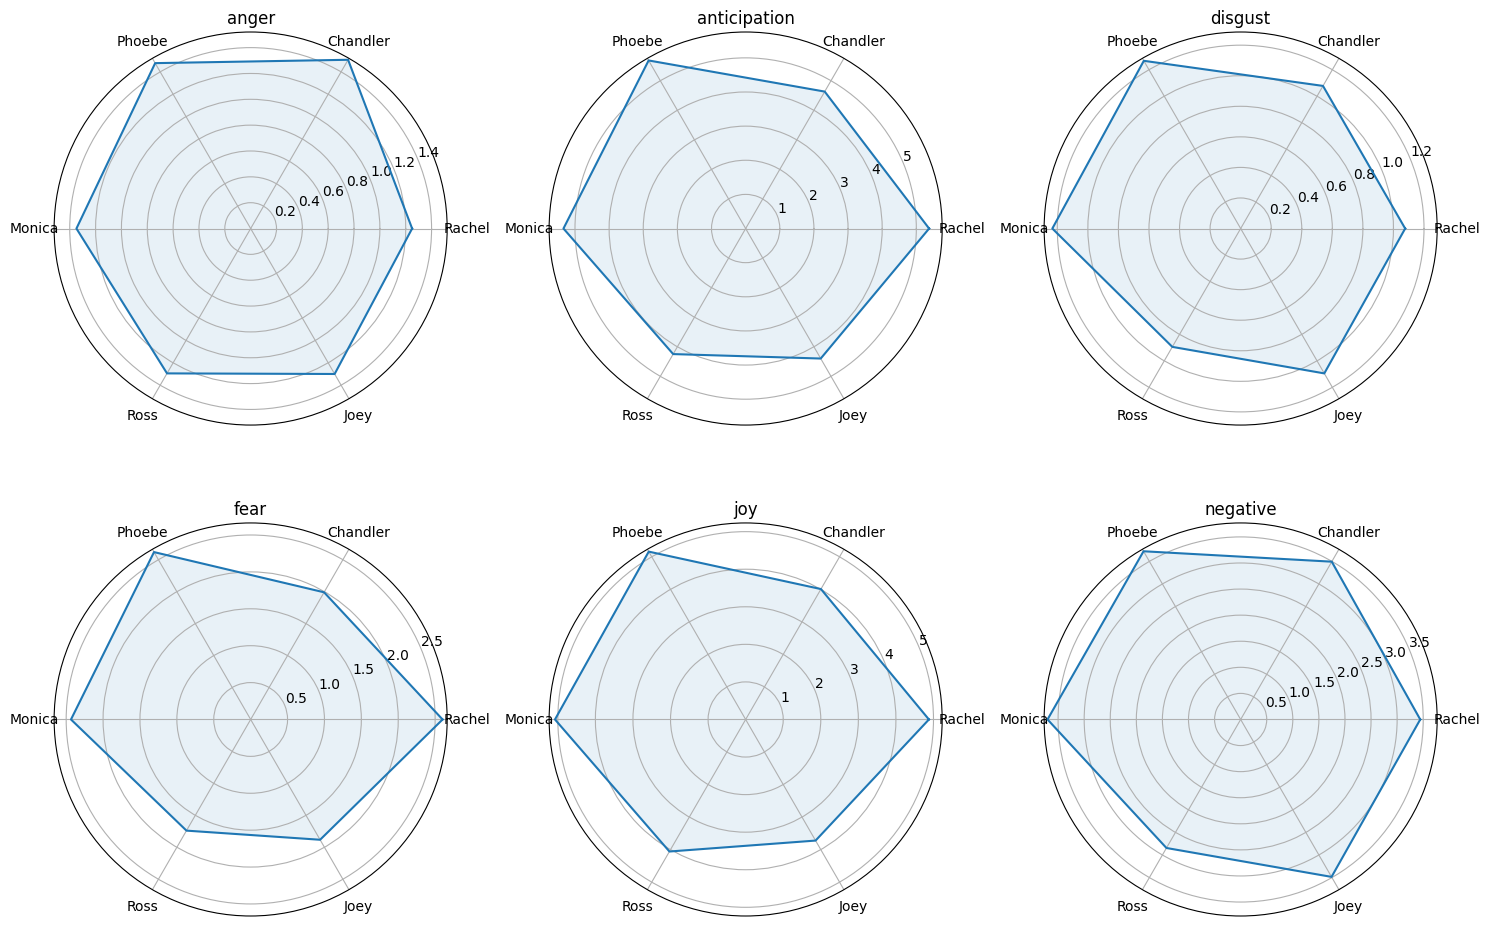

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(polar=True))
axs = axs.flatten() # 2D ızgara düzenini 1D listeye dönüştür

# Tüm konuşmacıların skorlarını her duygu için topla
emotion_scores = {emotion: [] for emotion in all_emotions[list(all_emotions.keys())[0]].keys()}
for speaker, scores in all_emotions.items():
    for emotion, score in scores.items():
        emotion_scores[emotion].append(score)

# Her duygu için bir radar grafiği çiz
for ax, (emotion, scores) in zip(axs, emotion_scores.items()):
    values = scores
    categories = list(all_emotions.keys())
    N = len(categories)
    values += values[:1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax.set_xticks(angles[:-1], categories, rotation=45)
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.1)
    ax.set_title(emotion)

# Grafikleri göster
plt.tight_layout()
plt.show()
